# takingdata数据基本情况分析
> 该数据为takingdata提供的虚假欺诈点击数据，一共184903890行，数据集大小7.5GB

> 变量名词与相关解释如下：

* ip: 客户ip 地址
* app: app id 
* device: 用户手机终端信号 (e.g., iphone 6 plus, iphone 7, huawei mate 7, etc.)
* os: 系统版本id
* channel: 广告渠道 id 
* click_time: 点击时间
* attributed_time: app 下载时间
* is_attributed: 该次点击是否下载app

**注意：**以上ip,app,device,os,channel都已经进行了转码处理

### 1.环境准备
**导入模块**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from IPython import display
%matplotlib inline

os.chdir("C:/MyDownloads/takingdata")

**创建迭代器读取数据，并查看数据**

In [2]:
chunks = pd.read_csv('train.csv',  chunksize=2000000)

In [3]:
chunks.get_chunk(5)

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,83230,3,1,13,379,2017-11-06 14:32:21,NaN,0
1,17357,3,1,19,379,2017-11-06 14:33:34,NaN,0
2,35810,3,1,13,379,2017-11-06 14:34:12,NaN,0
3,45745,14,1,13,478,2017-11-06 14:34:52,NaN,0
4,161007,3,1,13,379,2017-11-06 14:35:08,NaN,0


**说明:**由于数据集非常大，可以看到click_time, attributed_time是时间数据，attributed_time有大量缺失值

**统计各离散变量unique数**

In [5]:
chunks = pd.read_csv('train.csv',  chunksize=2000000)
ip_set = set()
app_set = set()
channel_set = set()
os_set = set()
device_set = set()

print('programme start!')  
for chunk in chunks:
    
    ip_list = chunk['ip']
    app_list = chunk['app']
    channel_list = chunk['channel']
    os_list = chunk['os']
    device_list = chunk['device']

    ip_set = set(ip_list) | ip_set
    app_set = set(app_list) | app_set
    channel_set = set(channel_list) |channel_set
    os_set = set(os_list) | os_set
    device_set = set(device_list) | device_set
    

print("progamme over!")

programme start!
progamme over!


**输出离散变量unique count的结果**


In [6]:
unique_series = pd.Series()
unique_series['ip'] = len(ip_set)
unique_series['app'] = len(app_set)
unique_series['channel'] = len(channel_set)
unique_series['os'] = len(os_set)
unique_series['device'] = len(device_set)

unique_series
    

ip         277396
app           706
channel       202
os            800
device       3475
dtype: int64

In [7]:
per_click = 184903890./277396
per_click

666.570137997664

**说明：**四天时间一共277396个ip通过各种渠道进行了访问，平均ip点击次数：666.57

**绘制除ip外离散变量unique条行图**

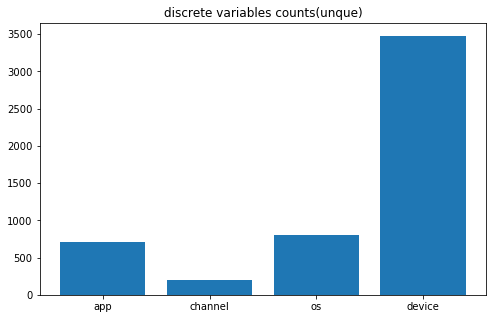

In [8]:
plt.figure(figsize=(8, 5))
plt.title('discrete variables counts(unque)')
unique_series = unique_series.drop('ip')
x = range(len(unique_series))
plt.bar(x, unique_series)
plt.xticks(x, unique_series.index)
plt.show()

In [9]:
# save file
unique_series.to_csv('unique_of_descrete.csv')

**统计app下载情况分布**

In [10]:
is_attributed_counts = pd.Series([0,0], index=[0, 1])

chunks = pd.read_csv('train.csv',  chunksize=2000000)

print('prog start!')
for chunk in chunks:
    
    c = chunk['is_attributed'].value_counts()
    is_attributed_counts[0] += c[0]
    is_attributed_counts[1] += c[1]
    
print('prog end')
print(is_attributed_counts)

prog start!
prog end
0    184447044
1       456846
dtype: int64


In [20]:
attributed_ratio = round((is_attributed_counts[1]/is_attributed_counts.sum()) * 100, 4)
print("attributed_ratio is  {}% ".format(attributed_ratio))

attributed_ratio is  0.2471% 


**说明：**样本非常不均匀，下载了app的点击比例非常稀少，可以作barplot进行可视化

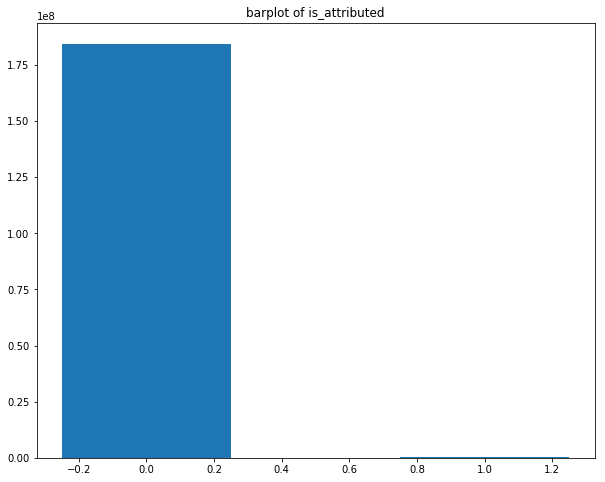

In [13]:
plt.figure(figsize=(10, 8))
plt.title('barplot of is_attributed')
plt.bar(is_attributed_counts.index, is_attributed_counts, width=0.5)

plt.show()

In [21]:
#save res
is_attributed_counts.to_csv('is_attributed_counts.csv')


**统计每一个ip访问次数**

In [22]:

chunks = pd.read_csv('train.csv',  chunksize=2000000)

ip_counts = pd.Series()

print('progamme start!')
for chunk in chunks:
    ip_c = chunk['ip'].value_counts()
    ip_counts = ip_counts.append(ip_c, ignore_index=False)

print('progamme end!')


progamme start!
progamme end!


In [23]:
ip_counts = ip_counts.groupby(ip_counts.index).sum()

**绘制累积分布图&频数分布直方图**

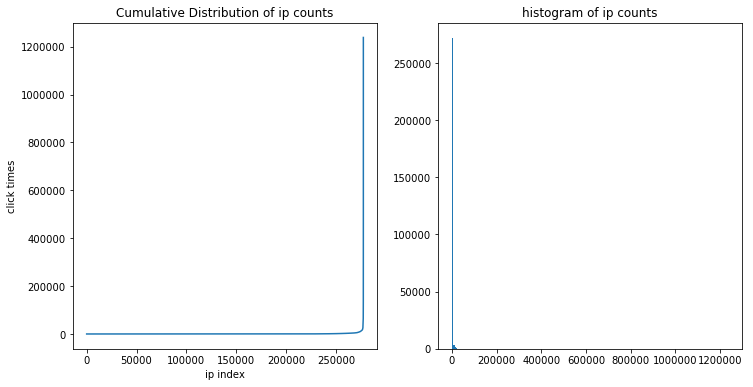

In [24]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.title('Cumulative Distribution of ip counts')
plt.plot(ip_counts.sort_values().values)
plt.ylabel('click times')
plt.xlabel('ip index')

plt.subplot(122)
plt.title('histogram of ip counts')
plt.hist(ip_counts, bins=200)
plt.show()

In [26]:
print(round(ip_counts.describe(), 4))

count    2.773960e+05
mean     6.665701e+02
std      5.446831e+03
min      1.000000e+00
25%      3.000000e+00
50%      1.300000e+01
75%      1.490000e+02
max      1.238734e+06
dtype: float64


In [27]:
# save res
ip_counts.to_csv("ip_counts.csv")

**查看异常高频点击ip，并统计相关比例**

In [48]:
three_sigma_plus = ip_counts.mean() + (3*ip_counts.std())
ip_counts_is_outlier = np.where(ip_counts > three_sigma_plus, 1, 0)
ip_counts_is_outlier = pd.Series(ip_counts_is_outlier, index=ip_counts.index)
print(ip_counts_is_outlier.value_counts())

0    276326
1      1070
dtype: int64


**说明**从中我们可以看出，超出+3sigma的ip地址比例不高，可以查看一下是否下载和这些ip之间的关系

In [33]:
chunks = pd.read_csv('train.csv',  chunksize=2000000)

ip_attr_counts = pd.Series()

print('progamme start!')
for chunk in chunks:
    ip_c = chunk['is_attributed'].groupby(chunk['ip']).sum()
    ip_attr_counts = ip_attr_counts.append(ip_c, ignore_index=False)

print('progamme end!')

progamme start!
progamme end!


In [43]:
ip_attr_counts = ip_attr_counts.groupby(ip_attr_counts.index).sum()

In [50]:
ip_counts_df = pd.concat([ip_counts_is_outlier.sort_index(),
                          ip_counts.sort_index(),
                          ip_attr_counts.sort_values()], axis=1)
ip_counts_df.columns = ['is_outlier', 'click_times', 'attr_times']
ip_counts_df.head()

,is_outlier,click_times,attr_times
1,0,47,9
5,0,24,0
6,0,1454,2
9,0,4029,6
10,0,1180,3


In [53]:
g = ip_counts_df.groupby('is_outlier')
g['attr_times'].mean()

is_outlier
0     1.475594
1    45.888785
Name: attr_times, dtype: float64

点击越多，下载越多

**查看下载比例&是否下载和点击量异常高ip之间的关系**

In [54]:
ip_counts_df['is_attributed'] = np.where(ip_counts_df['attr_times']>0, 1, 0)
pd.crosstab(index=ip_counts_df['is_attributed'], columns=ip_counts_df['is_outlier'])

is_outlier,0,1
is_attributed,,
0,32358,0
1,243968,1070


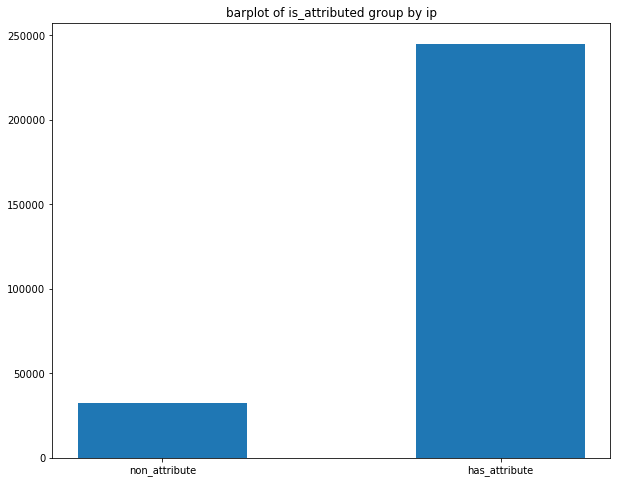

In [63]:
plt.figure(figsize=(10, 8))
plt.title('barplot of is_attributed group by ip')
c = ip_counts_df['is_attributed'].value_counts()
plt.bar(c.index, c, width=0.5)
plt.xticks((0, 1), ('non_attribute', 'has_attribute'))
plt.show()


In [55]:
ip_counts_df['attr_ratio'] = ip_counts_df['attr_times']/ip_counts_df['click_times']
ip_counts_df.describe().to_csv('ip_counts_desc.csv')

,is_outlier,click_times,attr_times,is_attributed,attr_ratio
count,277396.000000,2.773960e+05,277396.000000,277396.000000,277396.000000
mean,0.003857,6.665701e+02,1.646909,0.883351,0.256061
std,0.061987,5.446831e+03,8.023996,0.321002,0.351494
min,0.000000,1.000000e+00,0.000000,0.000000,0.000000
25%,0.000000,3.000000e+00,1.000000,1.000000,0.002200
50%,0.000000,1.300000e+01,1.000000,1.000000,0.066667
75%,0.000000,1.490000e+02,1.000000,1.000000,0.333333
max,1.000000,1.238734e+06,2340.000000,1.000000,1.000000


In [217]:
ip_counts_df.describe().to_csv('ip_counts_desc.csv')

**结论：**

* 数据分布极不均匀，有少数ip点击次数极多,
* 点击量异常高的ip下载也高，并且可以看到，点击量极高的1070个ip里没有下载的数量为0
* 平均下载比例为0.25，也就是说一个ip平均每4次点击就会产生一次下载行为
* 大部分ip都有过下载行为,也就是说，有少数ip，可能导致了大量的无效点击

In [56]:
#save res
ip_counts_df.to_csv('ip_counts.csv')

**分析app变量**

In [66]:
chunks = pd.read_csv('train.csv',  chunksize=2000000)

app_counts = pd.Series()
app_attr_times = pd.Series()

print('progamme start!')
for chunk in chunks:
    c_1 = chunk['app'].value_counts()
    c_2 = chunk['is_attributed'].groupby(chunk['app']).sum()
    #c = pd.concat([c_1.sort_index(), c_2.sort_index], axis=1)
    app_counts = app_counts.append(c_1, ignore_index=False)
    app_attr_times = app_attr_times.append(c_2, ignore_index=False)

print('progamme end!')

progamme start!
progamme end!


In [71]:
app_counts = app_counts.groupby(app_counts.index).sum()
app_attr_times = app_attr_times.groupby(app_attr_times.index).sum()

In [76]:
app_stats = pd.DataFrame(index=app_counts.index)
app_stats['click_times'] = app_counts.sort_index() 
app_stats['attr_times'] = app_attr_times.sort_index()
app_stats.head()

,click_times,attr_times
0,3248,1005
1,5796274,1230
2,21642136,5661
3,33911780,10261
4,126275,5


In [77]:
app_stats.describe()

,click_times,attr_times
count,7.060000e+02,706.000000
mean,2.619035e+05,647.090652
std,2.118369e+06,6081.710349
min,1.000000e+00,0.000000
25%,2.000000e+00,0.000000
50%,2.900000e+01,0.000000
75%,7.532500e+02,3.000000
max,3.391178e+07,132390.000000


**说明：**

* 平均每个app下载次数为647，而点击次数为26w以上，平均点击后下载率为仅6%
* 绝大部分app没有下载几率

In [78]:
app_stats['attr_ratio'] = app_stats.attr_times/ app_stats.click_times
app_stats.attr_ratio.describe()

count    706.000000
mean       0.064204
std        0.161892
min        0.000000
25%        0.000000
50%        0.000000
75%        0.008699
max        1.000000
Name: attr_ratio, dtype: float64

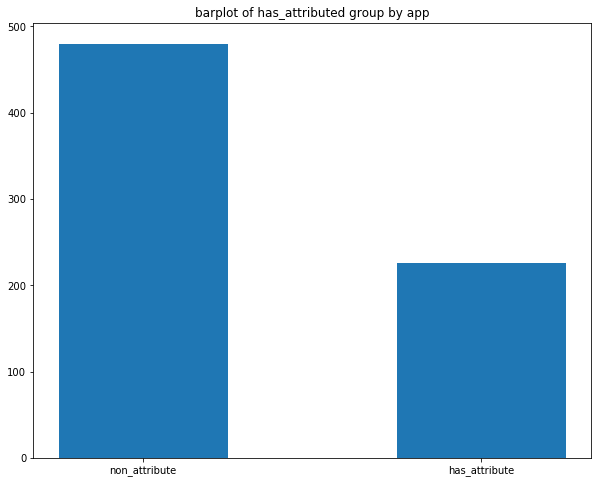

In [80]:
app_stats['has_attributed'] = np.where(app_stats['attr_times'] > 0, 1, 0)
plt.figure(figsize=(10, 8))
plt.title('barplot of has_attributed group by app')
c = app_stats['has_attributed'].value_counts()
plt.bar(c.index, c, width=0.5)
plt.xticks((0, 1), ('non_attribute', 'has_attribute'))
plt.show()


In [220]:
# save res
app_stats.to_csv("app_stats.csv")
app_stats.sort_values(by='click_times', ascending=False).head()

,click_times,attr_times,attr_ratio,has_attributed
3,33911780,10261,0.000303,1
12,24179003,2640,0.000109,1
2,21642136,5661,0.000262,1
9,16458268,18823,0.001144,1
15,15958970,3418,0.000214,1


**分析channel变量**

In [85]:

def discrete_anna(varname):

    chunks = pd.read_csv('train.csv',  chunksize=2000000)

    counts = pd.Series()
    attr_times = pd.Series()

    print('loop start of {}'.format(varname))
    for chunk in chunks:
        c_1 = chunk[varname].value_counts()
        c_2 = chunk['is_attributed'].groupby(chunk[varname]).sum()
        #c = pd.concat([c_1.sort_index(), c_2.sort_index], axis=1)
        counts = counts.append(c_1, ignore_index=False)
        attr_times = attr_times.append(c_2, ignore_index=False)

    print('loop end of {} '.format(varname))
    counts = counts.groupby(counts.index).sum()
    attr_times = attr_times.groupby(attr_times.index).sum()
    
    return counts, attr_times

In [86]:
channel_counts, channel_attr = discrete_anna('channel')
os_counts, os_attr = discrete_anna('os')
device_counts, device_attr = discrete_anna('device')

loop start!
loop end!
loop start!
loop end!
loop start!
loop end!


In [ ]:
channel_stat = pd.DataFrame()
channel_stat['counts'] = channel_counts.sort_index()
channel_stat['attr_times'] = channel_attr
channel_stat.attr_times.sum()

In [91]:
channel_stat['has_attributed'] = np.where(channel_stat.attr_times > 0, 1, 0)
channel_stat['attribute_rate'] = channel_stat['attr_times']/channel_stat['counts']
channel_stat.describe()

,counts,attr_times,has_attributed,attribute_rate
count,2.020000e+02,202.000000,202.000000,202.000000
mean,9.153658e+05,2261.613861,0.861386,0.043271
std,1.815411e+06,10994.376570,0.346402,0.138098
min,1.000000e+00,0.000000,0.000000,0.000000
25%,4.234500e+03,12.000000,1.000000,0.000153
50%,1.077880e+05,156.500000,1.000000,0.000457
75%,1.019082e+06,813.000000,1.000000,0.003615
max,1.506593e+07,133070.000000,1.000000,0.952450


**说明：**

* 86%以上的channel有下载过记录，最高为1.3w
* 平均渠道访问量为91.5w，平均下载量为2261次
* 平均点击后的下载概率为4.3%

In [98]:
# save res
channel_stat.to_csv('channel_stat.csv')

**查看每个渠道下载和点击次数的频数分布情况**

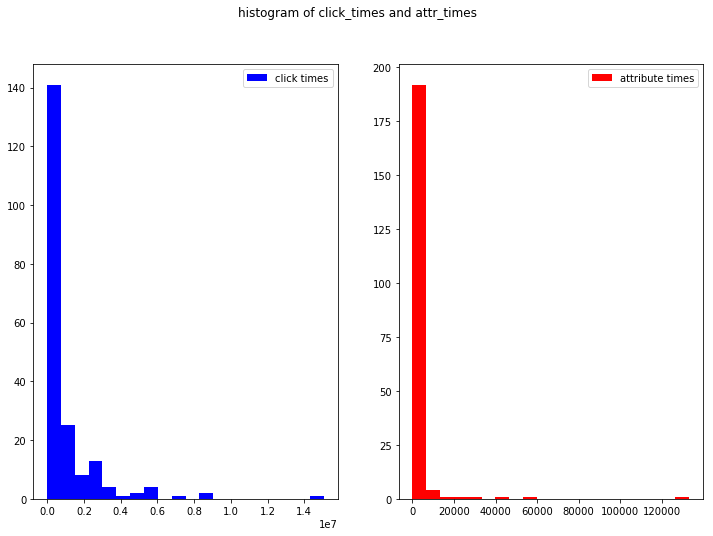

In [95]:

plt.figure(figsize=(12, 8))
plt.subplot(121)
plt.suptitle('histogram of click_times and attr_times')
plt.hist(x=channel_stat['counts'], bins=20, color='blue', label='click times')
plt.legend(loc='best')
plt.subplot(122)
plt.hist(x=channel_stat['attr_times'], bins=20, color='red', label='attribute times')
plt.legend(loc='best')


plt.show()

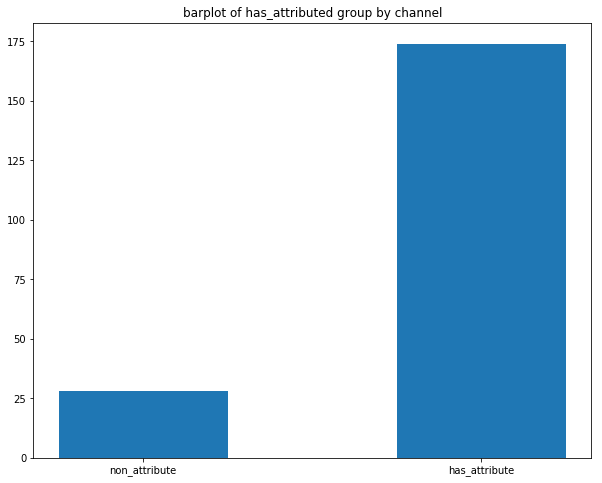

In [224]:
channel_stat['has_attributed'] = np.where(channel_stat['attr_times'] > 0, 1, 0)
plt.figure(figsize=(10, 8))
plt.title('barplot of has_attributed group by channel')
c = channel_stat['has_attributed'].value_counts()
plt.bar(c.index, c, width=0.5)
plt.xticks((0, 1), ('non_attribute', 'has_attribute'))
plt.show()

In [223]:
channel_stat.has_attributed.value_counts()

1    174
0     28
Name: has_attributed, dtype: int64

**分析os变量**

In [97]:
os_stats = pd.DataFrame()

os_stats = pd.DataFrame()
os_stats['click_times'] = os_counts.sort_index()
os_stats['attr_times'] = os_attr
os_stats.attr_times.sum()

os_stats['has_attributed'] = np.where(os_stats.attr_times > 0, 1, 0)
os_stats['attribute_rate'] = os_stats['attr_times'] / os_stats['click_times']
os_stats.describe()

,click_times,attr_times,has_attributed,attribute_rate
count,8.000000e+02,800.000000,800.000000,800.000000
mean,2.311299e+05,571.057500,0.145000,0.007943
std,2.221556e+06,4423.013376,0.352321,0.057189
min,1.000000e+00,0.000000,0.000000,0.000000
25%,1.000000e+00,0.000000,0.000000,0.000000
50%,3.000000e+00,0.000000,0.000000,0.000000
75%,7.350000e+01,0.000000,0.000000,0.000000
max,4.418191e+07,79669.000000,1.000000,0.925237


**只有少数os有下载记录，可以用barplot表示**

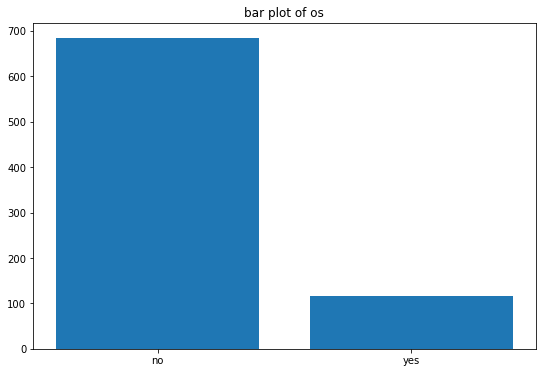

In [99]:
plt.figure(figsize=(9, 6))
plt.title('bar plot of os')
c = os_stats.has_attributed.value_counts()
plt.bar(c.index, c)
plt.xticks(c.index, ('no', 'yes'))
plt.show()

In [100]:
# save res
os_stats.to_csv("os_stats.csv")

** device 类型探索**

In [101]:
device_stats = pd.DataFrame()

device_stats = pd.DataFrame()
device_stats['click_times'] = device_counts.sort_index()
device_stats['attr_times'] = device_attr
device_stats.attr_times.sum()

device_stats['has_attributed'] = np.where(device_stats.attr_times > 0, 1, 0)
device_stats['attribute_rate'] = device_stats['attr_times'] / device_stats['click_times']
device_stats.describe()

,click_times,attr_times,has_attributed,attribute_rate
count,3.475000e+03,3475.000000,3475.000000,3475.000000
mean,5.320975e+04,131.466475,0.537842,0.149752
std,2.960519e+06,5478.919685,0.498638,0.230485
min,1.000000e+00,0.000000,0.000000,0.000000
25%,1.000000e+00,0.000000,0.000000,0.000000
50%,4.000000e+00,1.000000,1.000000,0.076923
75%,1.800000e+01,2.000000,1.000000,0.200000
max,1.743301e+08,306495.000000,1.000000,1.000000


**说明：**

* 一半左右的device有过下载记录
* 平均每种device点击次数为53209次，下载为131.5， 平均下载率15%
* 点击和下载依然分布不均匀，大部分处于比较低位的水平，也许和用户量有关

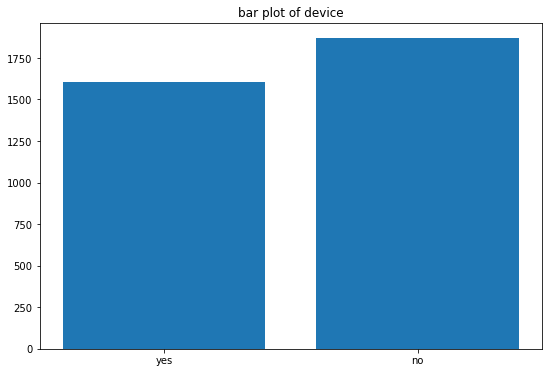

In [225]:
plt.figure(figsize=(9, 6))
plt.title('bar plot of device')
c = device_stats.has_attributed.value_counts()
plt.bar(c.index, c)
plt.xticks(c.index, ('no', 'yes'))
plt.show()

In [102]:
# save res
device_stats.to_csv('device_stats.csv')

### 时间区间统计分析

**数据预处理&变量和中间表统计**

In [133]:
from datetime import datetime
chunks = pd.read_csv('train.csv',  chunksize=2000000)

click_by_date_hour = pd.Series()
attributed_by_date_hour = pd.Series()

for chunk in chunks:
    
    chunk['click_time'] = pd.to_datetime(chunk['click_time'], format='%Y-%m-%d  %H:%M:%S', errors='raise')
    chunk['attributed_time'] = pd.to_datetime(chunk['attributed_time'], format='%Y-%m-%d  %H:%M:%S', errors='raise')
    
    chunk['click_date'] = chunk['click_time'].dt.date
    chunk['attributed_date'] = chunk['attributed_time'].dt.date
    
    chunk['click_hour'] = chunk['click_time'].dt.hour
    chunk['attributed_hour'] = chunk['attributed_time'].dt.hour
    
    s1 = chunk.groupby(['click_date','click_hour'])['click_time'].count()
    s2 = chunk.groupby(['click_date','click_hour'])['is_attributed'].sum()
    click_by_date_hour = click_by_date_hour.append(s1, ignore_index=False)
    attributed_by_date_hour = attributed_by_date_hour.append(s2, ignore_index=False)
    
    


In [112]:
click_date = click_date.groupby(click_date.index).sum()
click_date

2017-11-06     9308568
2017-11-07    59633310
2017-11-08    62945075
2017-11-09    53016937
dtype: int64

In [113]:
attributed_date.groupby(attributed_date.index).sum()

2017-11-06     10717
2017-11-07    152417
2017-11-08    151761
2017-11-09    141951
dtype: int64

In [140]:
click_by_date_hour.to_csv('click_by_date_hour.csv')

In [141]:
attributed_by_date_hour.to_csv('attributed_by_date_hour.csv')

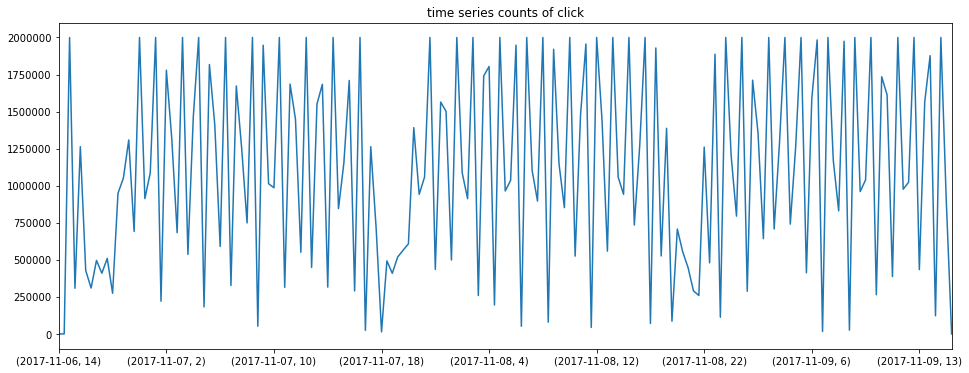

In [152]:
plt.figure(figsize=(16, 6))
plt.title("time series counts of click")


click_by_date_hour.plot(kind='line')
plt.show()

In [155]:
click_by_date_hour_df = pd.DataFrame()
click_by_date_hour_df['click_times'] = click_by_date_hour
click_by_date_hour_df['click_datetime']  = click_by_date_hour.index

In [156]:
click_by_date_hour_df.head()

,click_times,click_datetime
"(2017-11-06, 14)",48,"(2017-11-06, 14)"
"(2017-11-06, 15)",435,"(2017-11-06, 15)"
"(2017-11-06, 16)",1999517,"(2017-11-06, 16)"
"(2017-11-06, 16)",308260,"(2017-11-06, 16)"
"(2017-11-06, 17)",1263348,"(2017-11-06, 17)"


In [166]:
click_by_date_hour_df['click_date'] = click_by_date_hour_df['click_datetime'].map(lambda x:x[0])
click_by_date_hour_df['click_hour'] = click_by_date_hour_df['click_datetime'].map(lambda x:x[1])

In [167]:
click_by_date_hour_df.head()

,click_times,click_datetime,click_date,click_hour
"(2017-11-06, 14)",48,"(2017-11-06, 14)",2017-11-06,14
"(2017-11-06, 15)",435,"(2017-11-06, 15)",2017-11-06,15
"(2017-11-06, 16)",1999517,"(2017-11-06, 16)",2017-11-06,16
"(2017-11-06, 16)",308260,"(2017-11-06, 16)",2017-11-06,16
"(2017-11-06, 17)",1263348,"(2017-11-06, 17)",2017-11-06,17


In [169]:
click_by_date_hour = click_by_date_hour_df.groupby(['click_date','click_hour'])['click_times'].sum()

In [171]:
attributed_by_date_hour_df = pd.DataFrame()
attributed_by_date_hour_df['attribute_times'] = attributed_by_date_hour
attributed_by_date_hour_df['attributed_datetime'] = attributed_by_date_hour.index
attributed_by_date_hour_df['attributed_date'] = attributed_by_date_hour_df['attributed_datetime'].map(lambda x:x[0])
attributed_by_date_hour_df['attributed_hour'] = attributed_by_date_hour_df['attributed_datetime'].map(lambda x:x[1])


In [172]:
attributed_by_date_hour_df.head()

,attribute_times,attributed_datetime,attributed_date,attributed_hour
"(2017-11-06, 14)",0,"(2017-11-06, 14)",2017-11-06,14
"(2017-11-06, 15)",1,"(2017-11-06, 15)",2017-11-06,15
"(2017-11-06, 16)",3387,"(2017-11-06, 16)",2017-11-06,16
"(2017-11-06, 16)",529,"(2017-11-06, 16)",2017-11-06,16
"(2017-11-06, 17)",2241,"(2017-11-06, 17)",2017-11-06,17


In [173]:
attributed_by_date_hour.head()

(2017-11-06, 14)       0
(2017-11-06, 15)       1
(2017-11-06, 16)    3387
(2017-11-06, 16)     529
(2017-11-06, 17)    2241
dtype: int64

In [176]:
attributed_by_date_hour = attributed_by_date_hour_df.groupby(['attributed_date','attributed_hour'])['attribute_times'].sum()
attributed_by_date_hour.head()

attributed_date  attributed_hour
2017-11-06       14                    0
                 15                    1
                 16                 3916
                 17                 2241
                 18                 1343
Name: attribute_times, dtype: int64

In [177]:
attributed_by_date_hour_df.to_csv('attributed_by_date_hour_df.csv')

In [183]:
click_by_date_hour.tail()

click_date  click_hour
2017-11-09  12            3363917
            13            3457523
            14            3443283
            15            3026111
            16                447
Name: click_times, dtype: int64

时间区间为11-06， 到11-09四天，但是需要注意的是11-06仅从14点开始，11-09结束在16点。

In [184]:
attributed_by_date_hour.tail()

attributed_date  attributed_hour
2017-11-09       12                 8566
                 13                 8983
                 14                 7838
                 15                 4877
                 16                    0
Name: attribute_times, dtype: int64

In [188]:
click_by_date_hour.unstack().T.to_excel('click_datetime.xlsx')

In [189]:
attributed_by_date_hour.unstack().T.to_excel('attribute_datetime.xlsx')

In [191]:
click_by_date_hour = click_by_date_hour.unstack().T
attributed_by_date_hour = attributed_by_date_hour.unstack().T

In [192]:
click_by_date_hour

click_date,2017-11-06,2017-11-07,2017-11-08,2017-11-09
click_hour,,,,
0,NaN,3604365.0,3493769.0,3318301.0
1,NaN,3308150.0,3065649.0,3082862.0
2,NaN,3095633.0,3585843.0,3068887.0
3,NaN,3220271.0,3172056.0,3351149.0
4,NaN,3645493.0,3545132.0,4032691.0
5,NaN,3227349.0,3160269.0,3671741.0
6,NaN,2917284.0,2983655.0,3570940.0
7,NaN,2924033.0,3155262.0,3186240.0
8,NaN,2801293.0,2976057.0,2804701.0


In [205]:
click_by_date_hour.columns = ['2017-11-06', '2017-11-07', '2017-11-08', '2017-11-09']
attributed_by_date_hour.columns = ['2017-11-06', '2017-11-07', '2017-11-08', '2017-11-09']

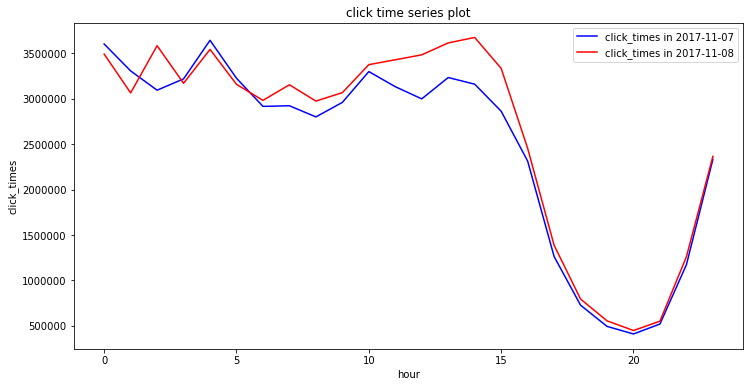

In [207]:
c = ['blue', 'red']
i = 0
plt.figure(figsize=(12, 6))
plt.title('click time series plot')
for day in ['2017-11-07', '2017-11-08']:
    
    plt.plot(click_by_date_hour.loc[:, day], color=c[i], label='click_times in {}'.format(day))
    plt.legend(loc='best')
    i += 1

plt.xlabel('hour')
plt.ylabel('click_times')
plt.show()

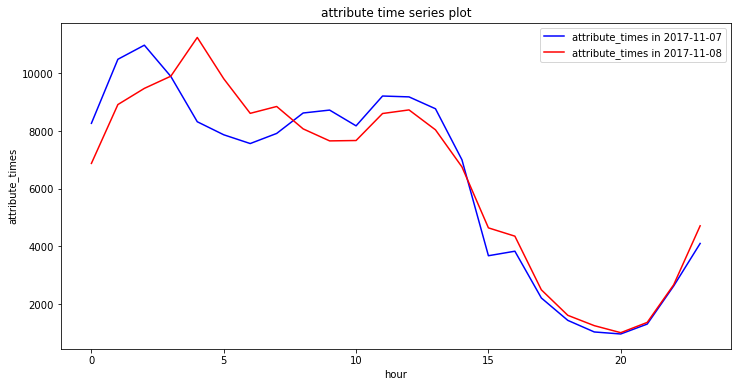

In [209]:
c = ['blue', 'red']
i = 0
plt.figure(figsize=(12, 6))
plt.title('attribute time series plot')
for day in ['2017-11-07', '2017-11-08']:
    
    plt.plot(attributed_by_date_hour.loc[:, day], color=c[i], label='attribute_times in {}'.format(day))
    plt.legend(loc='best')
    i += 1

plt.xlabel('hour')
plt.ylabel('attribute_times')
plt.show()

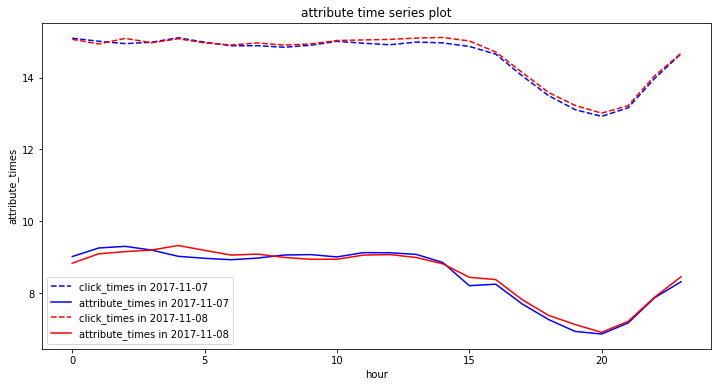

In [213]:
c = ['blue', 'red']
ty = ['b--', 'r--']
i = 0
plt.figure(figsize=(12, 6))
plt.title('attribute time series plot')
for day in ['2017-11-07', '2017-11-08']:
    plt.plot(np.log(click_by_date_hour.loc[:, day]), ty[i], label='click_times in {}'.format(day))
    plt.plot(np.log(attributed_by_date_hour.loc[:, day]), color=c[i], label='attribute_times in {}'.format(day))
    plt.legend(loc='best')
    i += 1

plt.xlabel('hour')
plt.ylabel('attribute_times')
plt.show()

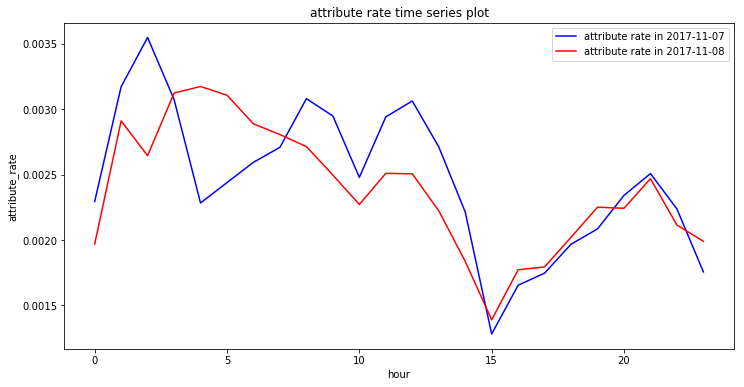

In [216]:
attributed_rate = pd.DataFrame(columns=attributed_by_date_hour.columns)

for day in attributed_by_date_hour.columns:
    
    attributed_rate[day] = attributed_by_date_hour[day]/click_by_date_hour[day]


c = ['blue', 'red']
i = 0
plt.figure(figsize=(12, 6))
plt.title('attribute rate time series plot')
for day in ['2017-11-07', '2017-11-08']:
    
    plt.plot(attributed_rate.loc[:, day], color=c[i], label='attribute rate in {}'.format(day))
    plt.legend(loc='best')
    i += 1

plt.xlabel('hour')
plt.ylabel('attribute_rate')
plt.show()

**结束**